In [1]:
import xmitgcm as xm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.figure_factory as ff
import sys
import xarray as xr

%matplotlib inline
%config InlineBackend.figure_format='retina'

Note that 2-D and 3-D arrays should be index-ordered as $(y,x)$ and $(z, y, x)$ respectively, to be written in proper ordering for MITgcm.

In [25]:
# Writing utility
def writefield(fname, data, dtype=np.dtype("float32")):
    dcopy = data.copy()
    print("write to file: " + fname)
    if dcopy.dtype != dtype:
        dcopy = dcopy.astype(dtype)
        print("changed dtype to " + str(dcopy.dtype))
    if sys.byteorder == "little":
        dcopy.byteswap(True)
    fid = open(fname, "wb")
    dcopy.tofile(fid)
    fid.close()

In [26]:
def openfield(fname, shape, dtype=np.dtype("float32")):
    data = np.fromfile(fname, dtype)
    if sys.byteorder == "little":
        data.byteswap(True)
    return data.reshape(shape)

# Set up grid

In [30]:
Ho = -3982.2607  # ocean depth in meters

Lx = 1000
Ly = 2000

nx = 20  # number of gridpoints in x-direction - 1000km/5km
ny = 40  # number of gridpoints in y-direction - 2000km/5km
nz = 49  # number of vertical levels

dx = Lx / nx
dy = Ly / ny

X = np.linspace(0, Lx, nx, dtype="float32")
Y = np.linspace(0, Ly, ny, dtype="float32")

XX, YY = np.meshgrid(X, Y)

# Bathymetry

In [31]:
# Flat bottom at z=-Ho
h = -Ho * np.ones((ny, nx), dtype="float32")
h[(0, -1), :] = 0  # Walls at top and bottom of domain

# Load pickup data

In [32]:
ds = xm.open_mdsdataset(data_dir="/scratch/daanr/ACC_run_coarse/Diags", prefix=["2D_diags", "GM_diags", "state"], calendar="360_days", read_grid=True,
    geometry="cartesian")


In [33]:
float(ds.isel(time=69).time)/1e9 * 1000 / (360*24*60*60)

69.5

# Export binaries for U, V, $\Theta$ & $\eta$

In [34]:
writefield("pickup_temp.bin", ds.isel(time=69).THETA.values)

write to file: pickup_temp.bin


In [35]:
writefield("pickup_uvel.bin", ds.isel(time=69).UVEL.values)

write to file: pickup_uvel.bin


In [36]:
writefield("pickup_vvel.bin", ds.isel(time=69).VVEL.values)

write to file: pickup_vvel.bin


In [37]:
writefield("pickup_etan.bin", ds.isel(time=69).ETAN.values)

write to file: pickup_etan.bin


# Initial tracer (dummy salinity) setup

We release the initial tracer profile at concentration 1 psu. Initial profile is padded (10 boxes on each side) with exponential decay to prevent spurious oscillations.

In [65]:
X_release = int(ds.XC[10].data)
Y_release = int(ds.YC[20].data)
print(X_release, Y_release)

525000 1025000


In [66]:
XX, YY = np.meshgrid(ds.XC.data, ds.YC.data)

In [67]:
dist_to_release = np.sqrt(np.square(X_release - XX) + np.square(Y_release - YY))

The initial tracer distribution is 
$$
\begin{cases} 
    \left(\frac{1}{(2 e)^{r/50,000}}-\frac{1}{2 e}\right)/\left(1-\frac{1}{2e}\right) &\qquad r<=50,000 \text{ meters}\\
    0 &\qquad r>50,000 \text{ meters}
\end{cases}    
$$
where
$$
r = \sqrt{(X_r-X)^2 + (Y_r-Y)^2}
$$

In [68]:
S_3D = np.zeros((nz, ny, nx), dtype='float32')
S_3D[24, :, :] = np.where(dist_to_release/50000<=1,(1/np.power(2*np.exp(1), dist_to_release/50000)- 1/(2*np.exp(1)))/(1-1/(2*np.exp(1))), 0)

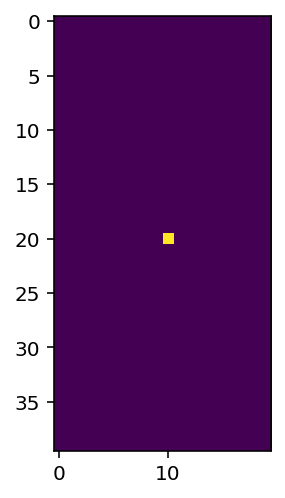

In [69]:
plt.imshow(S_3D[24, :, :])

In [70]:
S_3D[24, :, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

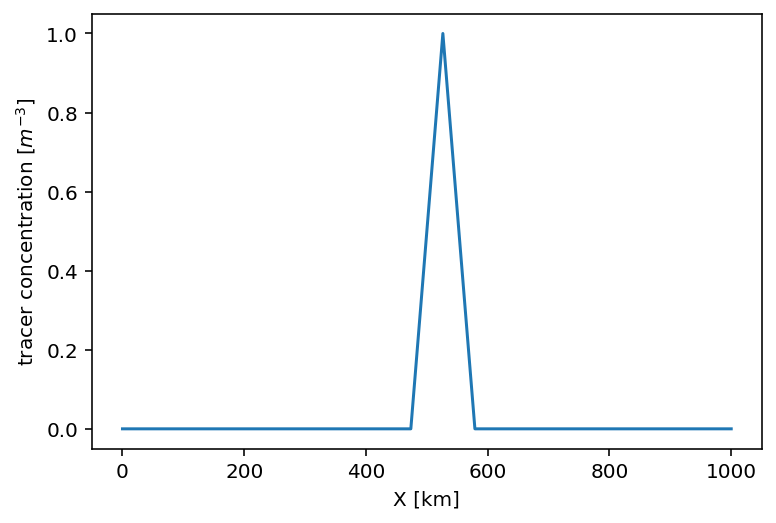

In [71]:
plt.plot(X, S_3D[24,20,:])
plt.xlabel('X [km]')
plt.ylabel(r'tracer concentration [$m^{-3}$]')
plt.show()

In [72]:
writefield("salinity_tracer_point.bin", S_3D)

write to file: salinity_tracer_point.bin
